# Clustering Iris dataset dengan K- Mean

In [3]:

%pip install pymysql
%pip install psycopg2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.5 MB/s eta 0:00:00


Kita ambil dataset dari database

In [4]:

import pymysql
import psycopg2
import numpy as np
import pandas as pd

def get_mysql_data():
    conn = pymysql.connect(
        host="pendatviomysql-39-projectvioo.h.aivencloud.com",
        user="avnadmin",
        password="AVNS_nnGCVuLriFaCit_hSPr",
        database="myiris",
        port=20305
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM irismysql")  # Select all records from the table
    data = cursor.fetchall()  # Fetch all rows
    conn.close()
    # Convert to Python list
    data_list = [list(row) for row in data]
    # Convert to NumPy array
    data_numpy = np.array(data_list)
    return data_list



def get_pg_data():
    conn = psycopg2.connect(
        host="pg-30810f3a-projectvioo.h.aivencloud.com",
        user="avnadmin",
        password="AVNS_zzD9DhqapmhcWhqwe5C",
        database="defaultdb",
        port=20305
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM iris_post")  # Select all records from the table
    data = cursor.fetchall()  # Fetch all rows
    cursor.close()
    conn.close()

    # Convert to Python list
    data_list = [list(row) for row in data]

    # Convert to NumPy array
    data_numpy = np.array(data_list)

    return data_list

columns = ['id', 'Class', 'sepal_length', 'sepal_width']
data_mysql = pd.DataFrame(get_mysql_data(), columns=columns)

columns = ['id', 'Class', 'petal_length', 'petal_width']
data_pg = pd.DataFrame(get_pg_data(), columns=columns)

df_merged = pd.merge(data_mysql, data_pg, on=["id", "Class"], how="inner")
print(df_merged)




      id           Class  sepal_length  sepal_width  petal_length  petal_width
0      1     Iris-setosa           1.4          0.2           5.1          3.5
1      2     Iris-setosa          14.0          2.0          40.9         30.0
2      3     Iris-setosa           1.3          0.2           4.7          3.2
3      4     Iris-setosa           1.5          0.2           4.6          3.1
4      5     Iris-setosa           1.4          0.2           5.0          3.6
..   ...             ...           ...          ...           ...          ...
145  146  Iris-virginica           5.2          2.3           6.7          3.0
146  147  Iris-virginica           5.0          1.9           6.3          2.5
147  148  Iris-virginica           5.2          2.0           6.5          3.0
148  149  Iris-virginica           5.4          2.3           6.2          3.4
149  150  Iris-virginica           5.1          1.8           5.9          3.0

[150 rows x 6 columns]



## Tahap Preprocessing
Pada tahap preprocessing, dilakukan serangkaian langkah untuk mempersiapkan data sebelum digunakan dalam proses pemodelan.
kali ini saya akan melakukan tahap preprocessing berikut :
1. Pembersihan data
2. Normalisasi data
3. Reduksi dimensi dengan Principal Component Analysys (PCA)





### Pembersihan data
dalam tahap ini kita akan membersihkan data dari Outlier atau data aneh yang dapat berpengaruh buruk pada kualitas model. Untuk membersihkan data,saya menggunakan LOF (local Outlier Factor) untuk mendeteksi Outlier dan memperbaiki nya menggunakan regresi linear, hal ini di lakukan untuk menghindari ketidakseimbangan data antar kelas bunga Iris dan juga menjaga jumlah data, dan alasan saya menggunakan regresi linear karena relatif sederhana dibandingkan algoritma regresi lain serta lebih akurat dibanding menggunakan rata rata / means.



-----------

In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor

# Dataframe awal dengan data kotor dan outlier
datab = df_merged.copy(deep=True)
feature_columns = ["sepal_length", "sepal_width", "petal_length", "petal_width"]

# Deteksi outlier menggunakan LOF
clf = LocalOutlierFactor(n_neighbors=20)
outlier_labels = clf.fit_predict(datab[feature_columns])
datab["outlier_label"] = outlier_labels

# Hitung jumlah data normal dan outlier
num_outliers = (datab["outlier_label"] == -1).sum()
num_normal = (datab["outlier_label"] == 1).sum()

# Pisahkan data menjadi normal dan outlier
df_normal = datab[datab["outlier_label"] == 1]
df_outlier = datab[datab["outlier_label"] == -1]

# Iterasi setiap kelas untuk memperbaiki outlier
classes = df_normal["Class"].unique()
for class_name in classes:
    # Filter data normal berdasarkan kelas
    class_data_normal = df_normal[df_normal["Class"] == class_name]

    # Dapatkan batas minimum dan maksimum untuk setiap fitur
    sepal_length_min = class_data_normal["sepal_length"].min()
    sepal_length_max = class_data_normal["sepal_length"].max()

    # Iterasi melalui data outlier pada kelas tersebut
    for idx, row in df_outlier[df_outlier["Class"] == class_name].iterrows():
        # Generate nilai random untuk sepal_length dalam batas normal
        random_sepal_length = np.random.uniform(sepal_length_min, sepal_length_max)

        # Gunakan regresi linear untuk memperbaiki fitur lainnya
        predictors = ["sepal_length"]  # Prediktor tunggal
        targets = ["sepal_width", "petal_length", "petal_width"]  # Target yang akan diprediksi

        for target in targets:
            # Latih regresi linear pada data normal
            model = LinearRegression()
            model.fit(class_data_normal[predictors], class_data_normal[target])

            # Prediksi nilai target berdasarkan nilai random
            predicted_value = model.predict(pd.DataFrame([[random_sepal_length]], columns=["sepal_length"]))

            # Perbarui nilai outlier
            datab.loc[idx, target] = predicted_value[0]

        # Ganti nilai random untuk sepal_length
        datab.loc[idx, "sepal_length"] = random_sepal_length


# Hapus kolom "outlier_label" setelah perbaikan
df_cleaned = datab.drop(columns=["outlier_label"])

# Hitung jumlah data setelah perbaikan
num_total = len(df_cleaned)

# Cetak hasil
print(f"Jumlah outlier yang terdeteksi: {num_outliers}")
print(f"Jumlah data normal: {num_normal}")
print(f"Jumlah total data setelah perbaikan: {num_total}")

# Dataframe hasil setelah perbaikan
# print(df_cleaned.to_string(index=False))


Jumlah outlier yang terdeteksi: 7
Jumlah data normal: 143
Jumlah total data setelah perbaikan: 150



### Normalisasi Data

Pada tahap ini, saya melakukan normalisasi data menggunakan dua metode berbeda, yaitu **StandardScaler** dan **MinMaxScaler**, untuk membandingkan hasil performa model pada tahap selanjutnya. Tujuan normalisasi adalah menyetarakan skala setiap fitur agar tidak ada fitur yang mendominasi proses analisis, terutama sebelum dilakukan reduksi dimensi dengan PCA.

#### 1. StandardScaler

Metode ini melakukan standardisasi fitur sehingga memiliki **mean = 0** dan **standard deviation = 1**. Rumus yang digunakan adalah:

$$
X_\text{scaled} = \frac{X - \mu}{\sigma}
$$

di mana:
- $( X $) adalah nilai asli,
- $( mu $)  adalah rata-rata (mean) dari fitur,
- $( $sigma ) adalah standar deviasi dari fitur.

StandardScaler cocok digunakan ketika data memiliki distribusi mendekati normal.


#### 2. MinMaxScaler

MinMaxScaler menskalakan fitur ke dalam rentang \([0, 1]\), dengan rumus:

$$
X_\text{scaled} = \frac{X - X_\text{min}}{X_\text{max} - X_\text{min}}
$$

di mana:
- \( X \) adalah nilai asli,
- \( X_\text{min} \) dan \( X_\text{max} \) masing-masing adalah nilai minimum dan maksimum dari fitur.

MinMaxScaler cocok untuk data yang tidak berdistribusi normal dan penting ketika fitur memiliki batas bawah dan atas tertentu.
--------------

Kedua metode dibandingkan berdasarkan hasil PCA dan akurasi model klasifikasi. Pemilihan metode akhir didasarkan pada kombinasi antara kestabilan model dan interpretabilitas fitur yang ditransformasi.

------------
### Reduksi Dimensi (PCA)
Setelah data dinormalisasi, saya menerapkan **Principal Component Analysis (PCA)** untuk mengurangi dimensi fitur sambil tetap mempertahankan informasi sebanyak mungkin. disini saya menggunakan PCA untuk:
- Mengurangi kompleksitas data.
- Mengurangi Dimensi agar dapat di plotting dalam 3d dan 2d

Penjelasan tahap preprocessing ini dapat dilihat lebih lengkap pada bagian *Table of Content → Preprocessing*.


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Pilih 4 fitur
features = ["sepal_length", "petal_length", "petal_width", "sepal_width"]

# --- 1. Tampilkan Data Asli Tanpa Reduksi dan Tanpa Normalisasi ---
print("=== Data Asli (Tanpa Reduksi & Normalisasi) ===")
print(df_cleaned[features].head())  # Cetak 5 baris pertama

# --- 2. Normalisasi Data ---
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df_cleaned[features])

df_normalized = pd.DataFrame(df_normalized, columns=features)

print("\n=== Data Setelah Normalisasi (Tanpa PCA) ===")
print(df_normalized.head())



=== Data Asli (Tanpa Reduksi & Normalisasi) ===
   sepal_length  petal_length  petal_width  sepal_width
0      1.400000       5.10000     3.500000     0.200000
1      1.457818       4.99944     3.427476     0.238428
2      1.300000       4.70000     3.200000     0.200000
3      1.500000       4.60000     3.100000     0.200000
4      1.400000       5.00000     3.600000     0.200000

=== Data Setelah Normalisasi (Tanpa PCA) ===
   sepal_length  petal_length  petal_width  sepal_width
0     -1.357554     -0.926584     1.102976    -1.313738
1     -1.324286     -1.053046     0.923471    -1.263209
2     -1.415094     -1.429615     0.360447    -1.313738
3     -1.300015     -1.555372     0.112938    -1.313738
4     -1.357554     -1.052342     1.350485    -1.313738


### Reduksi Dimensi (PCA)
Setelah data dinormalisasi, saya menerapkan **Principal Component Analysis (PCA)** untuk mengurangi dimensi fitur sambil tetap mempertahankan informasi sebanyak mungkin. disini saya menggunakan PCA untuk:
- Mengurangi kompleksitas data.
- Mempermudah visualisasi data dalam 2d dan 3d


=== Data Setelah PCA (2 Komponen) ===
      PCA_1     PCA_2
0 -2.330335  0.443297
1 -2.291961  0.236915
2 -2.389231 -0.433617
3 -2.310388 -0.704024
4 -2.472639  0.619958

=== Data Setelah PCA (3 Komponen) ===
      PCA_1     PCA_2     PCA_3
0 -2.330335  0.443297  0.127953
1 -2.291961  0.236915  0.039857
2 -2.389231 -0.433617 -0.058462
3 -2.310388 -0.704024 -0.111885
4 -2.472639  0.619958 -0.019156


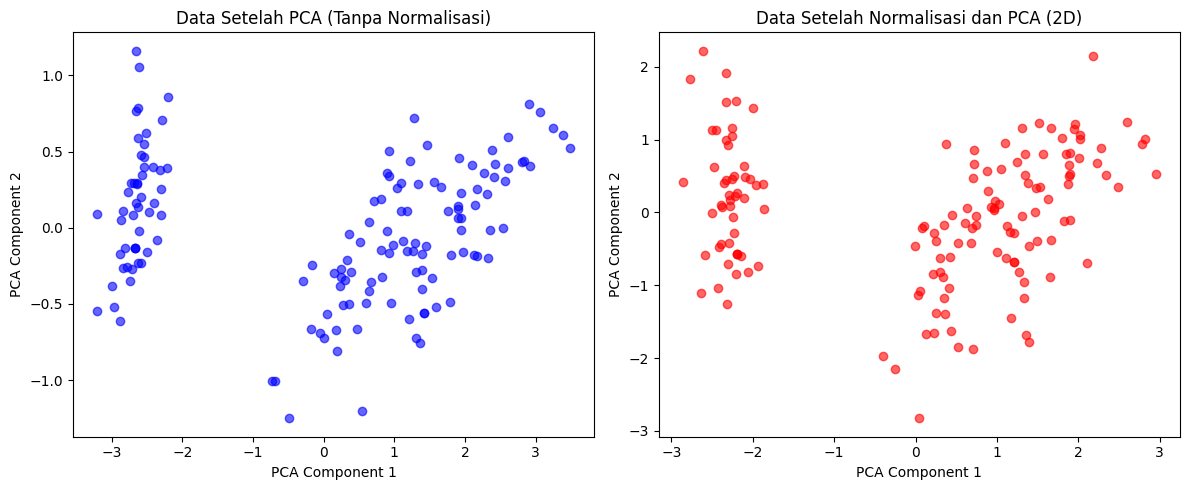

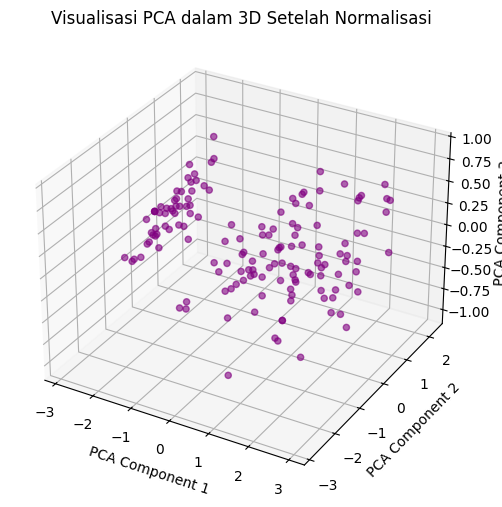

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# --- 3. Lakukan PCA (Reduksi Dimensi ke 2D) ---
pca_2d = PCA(n_components=2)
df_pca_2d = pca_2d.fit_transform(df_normalized)

df_pca_2d_df = pd.DataFrame(df_pca_2d, columns=["PCA_1", "PCA_2"])

print("\n=== Data Setelah PCA (2 Komponen) ===")
print(df_pca_2d_df.head())

# --- 4. Lakukan PCA (Reduksi Dimensi ke 3D) ---
pca_3d = PCA(n_components=3)
df_pca_3d = pca_3d.fit_transform(df_normalized)

df_pca_3d_df = pd.DataFrame(df_pca_3d, columns=["PCA_1", "PCA_2", "PCA_3"])

print("\n=== Data Setelah PCA (3 Komponen) ===")
print(df_pca_3d_df.head())

# --- 5. Visualisasi PCA Sebelum dan Setelah Normalisasi (2D) ---
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# PCA tanpa normalisasi
pca_raw = PCA(n_components=2)
df_pca_raw = pca_raw.fit_transform(df_cleaned[features])
df_pca_raw_df = pd.DataFrame(df_pca_raw, columns=["PCA_1", "PCA_2"])

ax[0].scatter(df_pca_raw_df["PCA_1"], df_pca_raw_df["PCA_2"], color='blue', alpha=0.6)
ax[0].set_xlabel("PCA Component 1")
ax[0].set_ylabel("PCA Component 2")
ax[0].set_title("Data Setelah PCA (Tanpa Normalisasi)")

# PCA setelah normalisasi
ax[1].scatter(df_pca_2d_df["PCA_1"], df_pca_2d_df["PCA_2"], color='red', alpha=0.6)
ax[1].set_xlabel("PCA Component 1")
ax[1].set_ylabel("PCA Component 2")
ax[1].set_title("Data Setelah Normalisasi dan PCA (2D)")

plt.tight_layout()
plt.show()


# --- 6. Visualisasi PCA dalam 3D ---
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca_3d_df["PCA_1"], df_pca_3d_df["PCA_2"], df_pca_3d_df["PCA_3"], color='purple', alpha=0.6)

ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("Visualisasi PCA dalam 3D Setelah Normalisasi")

plt.show()


## Tahap Clustering
Algoritma K-Means adalah salah satu metode clustering yang digunakan untuk mengelompokkan data ke dalam K jumlah kelompok berdasarkan kesamaan karakteristik.

Cara Kerja Algoritma K-Means
1. Tentukan jumlah kluster k

2. Menentukan Centroid Awal → Centroid adalah titik tengah dari masing-masing cluster, yang di insialisasi dengan dipilih secara acak

3. Mengelompokkan Data → Setiap data dihitung jaraknya dengan rumus eucldian distance ke centroid dan dimasukkan ke dalam cluster terdekat.

4. Mengupdate Centroid → Setelah semua data masuk ke cluster, centroid diperbarui dengan menghitung rata-rata atau means pada titik data dalam cluster dengan langkah ini centroid kemungkinan akan bergeser sedikit demi sedikit.

Iterasi Berulang → Langkah 3 dan 4 dilakukan berulang kali hingga centroid tidak berubah atau mencapai batas iterasi yang ditetapkan.


=== Hasil Clustering pada PCA 2D (3 Cluster) ===
      PCA_1     PCA_2  Cluster
0 -2.330335  0.443297        1
1 -2.291961  0.236915        1
2 -2.389231 -0.433617        1
3 -2.310388 -0.704024        1
4 -2.472639  0.619958        1


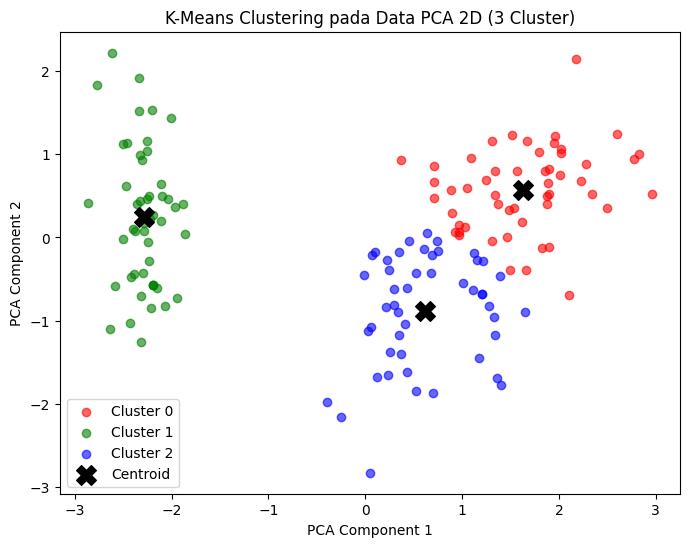


=== Hasil Clustering pada PCA 3D (2 Cluster) ===
      PCA_1     PCA_2     PCA_3  Cluster_2
0 -2.330335  0.443297  0.127953          1
1 -2.291961  0.236915  0.039857          1
2 -2.389231 -0.433617 -0.058462          1
3 -2.310388 -0.704024 -0.111885          1
4 -2.472639  0.619958 -0.019156          1


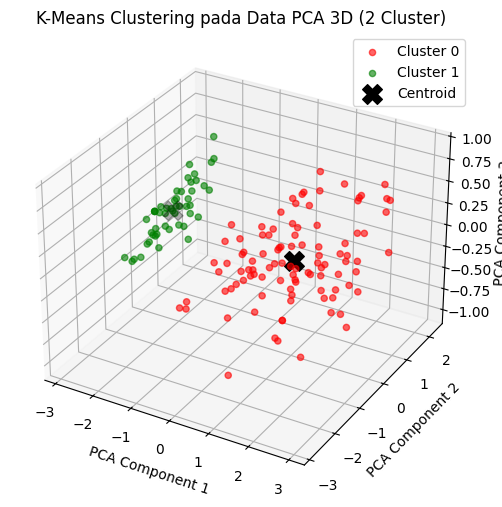


=== Hasil Clustering pada PCA 3D (3 Cluster) ===
      PCA_1     PCA_2     PCA_3  Cluster_2  Cluster_3
0 -2.330335  0.443297  0.127953          1          1
1 -2.291961  0.236915  0.039857          1          1
2 -2.389231 -0.433617 -0.058462          1          1
3 -2.310388 -0.704024 -0.111885          1          1
4 -2.472639  0.619958 -0.019156          1          1


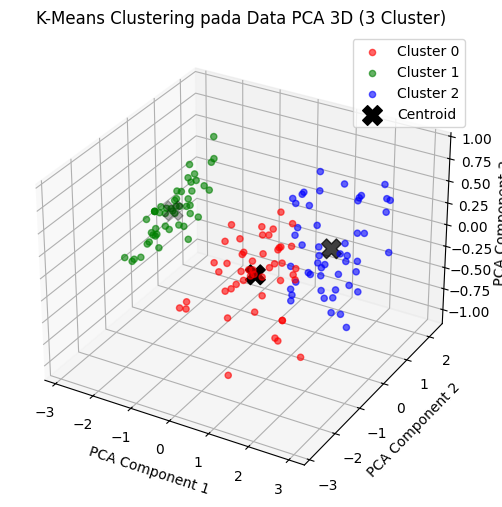


=== Hasil Clustering pada PCA 3D (4 Cluster) ===
      PCA_1     PCA_2     PCA_3  Cluster_2  Cluster_3  Cluster_4
0 -2.330335  0.443297  0.127953          1          1          0
1 -2.291961  0.236915  0.039857          1          1          0
2 -2.389231 -0.433617 -0.058462          1          1          3
3 -2.310388 -0.704024 -0.111885          1          1          3
4 -2.472639  0.619958 -0.019156          1          1          0


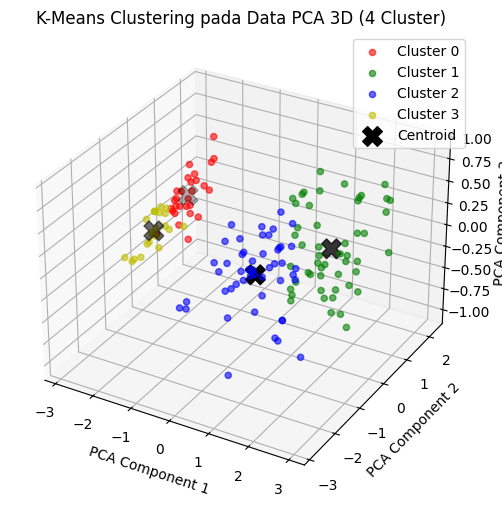

In [8]:
from sklearn.cluster import KMeans

# --- 1. Lakukan K-Means Clustering pada PCA 2D (3 Cluster) ---
kmeans_2d = KMeans(n_clusters=3, random_state=42, n_init=10)
df_pca_2d_df["Cluster"] = kmeans_2d.fit_predict(df_pca_2d_df)

print("\n=== Hasil Clustering pada PCA 2D (3 Cluster) ===")
print(df_pca_2d_df.head())

# Visualisasi hasil clustering PCA 2D
plt.figure(figsize=(8,6))
colors = ['r', 'g', 'b']
for cluster in range(3):
    clustered_data = df_pca_2d_df[df_pca_2d_df["Cluster"] == cluster]
    plt.scatter(clustered_data["PCA_1"], clustered_data["PCA_2"], color=colors[cluster], label=f"Cluster {cluster}", alpha=0.6)

# Tambahkan Centroid dalam bentuk "X"
centroids_2d = kmeans_2d.cluster_centers_
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], color='black', marker='X', s=200, label="Centroid")

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clustering pada Data PCA 2D (3 Cluster)")
plt.legend()
plt.show()

# --- 2. Lakukan K-Means Clustering pada PCA 3D (2, 3, dan 4 Cluster) ---
cluster_counts = [2, 3, 4]

for k in cluster_counts:
    kmeans_3d = KMeans(n_clusters=k, random_state=42, n_init=10)
    df_pca_3d_df[f"Cluster_{k}"] = kmeans_3d.fit_predict(df_pca_3d_df)

    print(f"\n=== Hasil Clustering pada PCA 3D ({k} Cluster) ===")
    print(df_pca_3d_df.head())

    # Visualisasi hasil clustering PCA 3D
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111, projection='3d')

    colors = ['r', 'g', 'b', 'y']
    for cluster in range(k):
        clustered_data = df_pca_3d_df[df_pca_3d_df[f"Cluster_{k}"] == cluster]
        ax.scatter(clustered_data["PCA_1"], clustered_data["PCA_2"], clustered_data["PCA_3"], color=colors[cluster], label=f"Cluster {cluster}", alpha=0.6)

    # Tambahkan Centroid dalam bentuk "X"
    centroids_3d = kmeans_3d.cluster_centers_
    ax.scatter(centroids_3d[:, 0], centroids_3d[:, 1], centroids_3d[:, 2], color='black', marker='X', s=200, label="Centroid")

    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.set_zlabel("PCA Component 3")
    ax.set_title(f"K-Means Clustering pada Data PCA 3D ({k} Cluster)")
    ax.legend()
    plt.show()


Kode di atas melakukan **clustering menggunakan K-Means** setelah data **dinormalisasi dan direduksi dengan PCA** di tahap sebelumnya.

Saya melakukan **Clustering** pada data hasil PCA 2D dengan **3 cluster** hanya sebagai pembanding saja, sedangkan untuk PCA 3D dilakukan dengan saya melakukan clustering dengan jumlah **2, 3, dan 4 cluster**.

dengan pendekatan ini membantu memahami pola distribusi data setelah transformasi PCA dan bagaimana K-Means mengelompokkan sampel berdasarkan pola yang diidentifikasi oleh komponen utama PCA.

## Tahap Evaluasi Clustering


K=2 --> SSE (Inertia): 198.1353, Silhouette Score: 0.6096
K=3 --> SSE (Inertia): 123.0623, Silhouette Score: 0.4713
K=4 --> SSE (Inertia): 100.9447, Silhouette Score: 0.4305
K=5 --> SSE (Inertia): 79.0766, Silhouette Score: 0.3678
K=6 --> SSE (Inertia): 68.7981, Silhouette Score: 0.3434
K=7 --> SSE (Inertia): 61.2296, Silhouette Score: 0.3324
K=8 --> SSE (Inertia): 53.0324, Silhouette Score: 0.3669
K=9 --> SSE (Inertia): 44.3639, Silhouette Score: 0.3668
K=10 --> SSE (Inertia): 39.7954, Silhouette Score: 0.3767


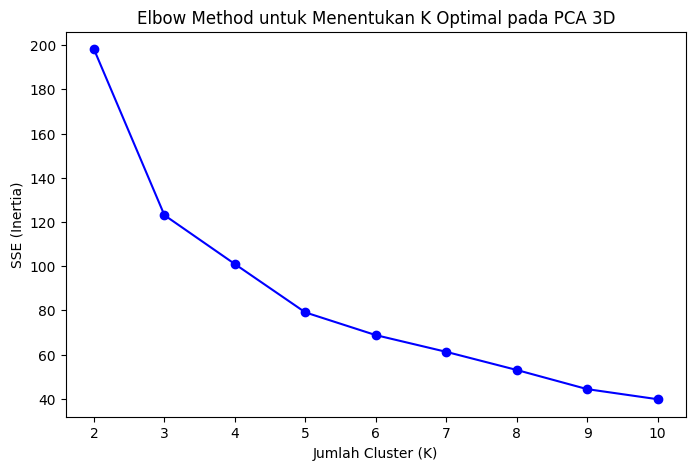

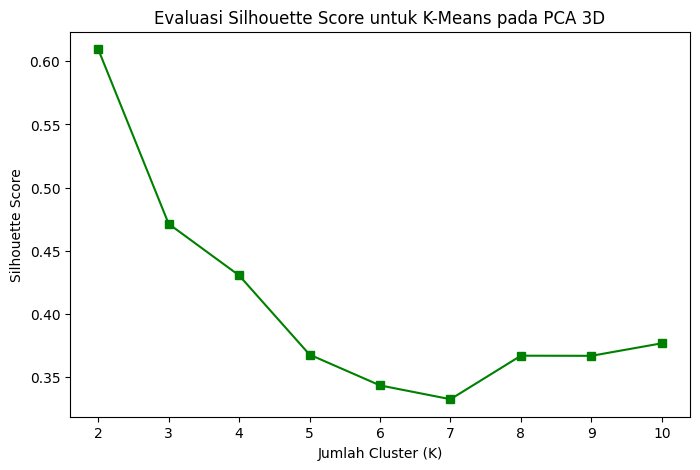

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Gunakan dataset PCA 3D yang sudah ada dari eksekusi sebelumnya
df_cluster = df_pca_3d_df.copy(deep=True)  # Salin dataset hasil PCA 3D

# Menentukan rentang K untuk evaluasi
max_clusters = min(10, len(df_cluster) - 1)  # Cegah nilai K terlalu besar
cluster_range = range(2, max_clusters + 1)

# Simpan hasil evaluasi
sse_values = []
silhouette_scores = []

# Iterasi untuk berbagai jumlah cluster
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_cluster)

    # Simpan SSE/Inertia
    sse_values.append(kmeans.inertia_)

    # Hitung silhouette score
    silhouette_avg = silhouette_score(df_cluster, labels)
    silhouette_scores.append(silhouette_avg)

    print(f"K={k} --> SSE (Inertia): {sse_values[-1]:.4f}, Silhouette Score: {silhouette_avg:.4f}")

# --- Plot Elbow Method ---
plt.figure(figsize=(8,5))
plt.plot(cluster_range, sse_values, marker='o', linestyle='-', color='b')
plt.xlabel("Jumlah Cluster (K)")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method untuk Menentukan K Optimal pada PCA 3D")
plt.xticks(cluster_range)
plt.show()

# --- Plot Silhouette Scores ---
plt.figure(figsize=(8,5))
plt.plot(cluster_range, silhouette_scores, marker='s', linestyle='-', color='g')
plt.xlabel("Jumlah Cluster (K)")
plt.ylabel("Silhouette Score")
plt.title("Evaluasi Silhouette Score untuk K-Means pada PCA 3D")
plt.xticks(cluster_range)
plt.show()


Kode ini melakukan evaluasi clustering dengan K-Means, menggunakan Elbow Method dan Silhouette Score untuk menentukan jumlah cluster optimal.

Dua fitur yang digunakan untuk clustering adalah petal_length dan petal_width dari dataset df_cleaned. Rentang K untuk clustering ditentukan dari 2 hingga 10 atau maksimal jumlah data - 1 , karena melakukan clustering K= 1 atau k = jumlah data adalah tidak masuk akal untuk clustering

Kemudian, perulangan dilakukan untuk mengevaluasi berbagai jumlah cluster (K=2 hingga K=10). Setiap iterasi, K-Means dijalankan, lalu dihitung SSE (inertia) untuk melihat seberapa rapat titik dalam cluster, dan Silhouette Score untuk mengukur pemisahan antar cluster. Nilai SSE dan Silhouette Score dicetak untuk analisis lebih lanjut.

Terakhir, dua grafik dibuat:
- Grafik Elbow method SSE inersia
- Grafik rata rata siluet

 Berdasarkan hasil analisis menggunakan Elbow Method, terjadi penurunan tajam pada nilai SSE (inertia) , dan nilai siluet yang relatif tinggi pada K = 3

menunjukkan bahwa pada titik ini, jumlah cluster cukup optimal. Meskipun Silhouette Score sedikit menurun di K=3, nilai tersebut tetap menjadi skor tertinggi kedua, ini menandakan bahwa pemisahan antar cluster masih cukup baik. Oleh karena itu saya rasa nilai optimal K = 3